# COVID-19 effect on Unemployment : part 4 - Industry
### by Martin Dionne

I analysed the following paper on the impact of COVID-19 on different industries.

## The CoRisk-Index: A data-mining approach to identify industry-specific risk assessments related to COVID-19 in real-time
#### 27th April 2020 - Fabian Stephany et al.

>The study presented here investigates a potential data source that could provide an empirical basis to identify industry-specific economic risks related to COVID-19 and to inform models on the economic effects of the current crisis. We examine company risk reports (10-K reports) filed to the U.S. Securities and Exchange Commission (SEC) and introduce a data-mining approach to measure firms’ risk assessments.
>
>...
>
>The empirical information provided could help to inform macro-economic models on the effects of the corona-crisis and, thus, help to inform policymakers to better target current economic support programmes to industries that report most severe risks at the current phase of the crisis.
>
>...
>
>The robustness of the results needs to be checked in more detail. In particular, we will compare historical and unemployment data with risk measures (text negativity) extracted from 10-K reports to investigate the correlation between risk reports and overall economic trends.

<div style="text-align:center"><img src="data/paper_results.png" /></div>

TLDR; They use mentions of COVID-19 in risk assesments reports (from SEC) to predict which industries should receive economic support. The main conclusion is that Retail, Hospitality and Manufacturing will be most impacted.

My goal is to validate the hypothesis and establish if it translate to the Canadian economy.

Source: https://arxiv.org/abs/2003.12432

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#import datetime as dt

In [2]:
# unemployment by industry (Canada) 
#https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410002201

df = pd.read_csv('data/1410002201_databaseLoadingData_ind2019_pt.csv')
#df

In [3]:
# function to get a year of data for specific industry
def query_year(df, geo='Canada', sex='Both sexes', age='15 years and over', 
               labor='Unemployment rate', naics='Total, all industries', year='2020'):

    df2 = df
    df2['DATE'] = pd.to_datetime(df2.REF_DATE)
    df2.DATE = df2.DATE.dt.strftime("%m")
    df2 = df2.loc[((df2.GEO == geo) & 
                   (df2.Sex == sex) &
                   (df2['Age group'] == age) &
                   (df2['Labour force characteristics'] == labor) &
                   (df2['North American Industry Classification System (NAICS)'] == naics) &
                   (df2.REF_DATE.str.contains(year))
                  )]
    return df2

In [4]:
unemp_2020 = query_year(df, year='2020')
unemp_2019 = query_year(df, year='2019')

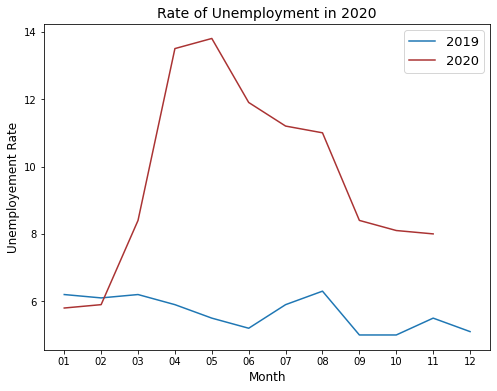

In [5]:
fig, ax = plt.subplots(nrows=1, sharey=True, figsize = (8,6))
ax.plot(unemp_2019.DATE, unemp_2019.VALUE, label = '2019')
ax.plot(unemp_2020.DATE, unemp_2020.VALUE, label = '2020', color ='#aa3333')
plt.title('Rate of Unemployment in 2020', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Unemployement Rate', fontsize = 12)
plt.legend(fontsize = 13, loc = 'upper right')
plt.show()

 We already demonstrated the link between COVID-19 and unemployment but what is the impact on different industries?

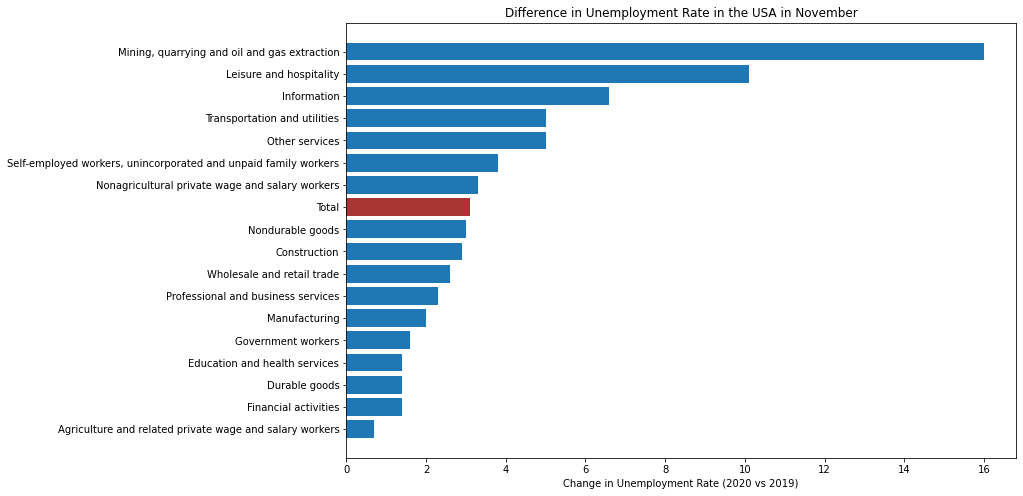

In [6]:
#https://www.bls.gov/web/empsit/cpseea31.htm
#https://www.bls.gov/news.release/empsit.t14.htm

us = pd.read_csv('data/bls-unemployment-nov.csv')
us['diff'] = us.URnov2020 - us.URnov2019
us = us.sort_values('diff', ascending=False)
us = us.set_index('Industries')

fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(us.index, us['diff'], align='center')
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate (2020 vs 2019)')
ax.set_title('Difference in Unemployment Rate in the USA in November')
highlight = 'Total'
pos = us.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')

A few notes about this graph:

* "Total" is the global change of unemployment rate
* This data is limited to the month of November but it gives an idea of the long lasting effect of COVID-19 on unemployment. 
* Leisure and hospitality (which include restaurants), is still one of most impacted industry.
* Keep in mind we measure a relative change we don't know the size of the industry (which can be misleading in the case of Mining industry).

Next step is to try to explain the differences with the paper and compare to Canada.

In [7]:
# function to get all industries for a specific month
def query_month(df, geo='Canada', sex='Both sexes', age='15 years and over', 
               labor='Unemployment rate', month='2020-11'):

    df2 = df
    df2['DATE'] = pd.to_datetime(df2.REF_DATE)
    df2.DATE = df2.DATE.dt.strftime("%m")
    df2 = df2.loc[((df2.GEO == geo) & 
                   (df2.Sex == sex) &
                   (df2['Age group'] == age) &
                   (df2['Labour force characteristics'] == labor) &
                   (df2.REF_DATE.str.contains(month))
                  )]
    df3 = pd.DataFrame()
    df3['NAICS'] = df2['North American Industry Classification System (NAICS)'].str.replace(r'\[.*\]', '').str.strip()
    df3[month] = df2.VALUE
    df3 = df3.sort_values(month, ascending=False)

    return df3

In [8]:
nov2020 = query_month(df, month='2020-11')
nov2019 = query_month(df, month='2019-11')
nov = nov2020.merge(nov2019, on='NAICS')
nov['diff'] = nov['2020-11'] - nov['2019-11']
nov = nov.sort_values('diff', ascending=False)
nov = nov.set_index('NAICS')

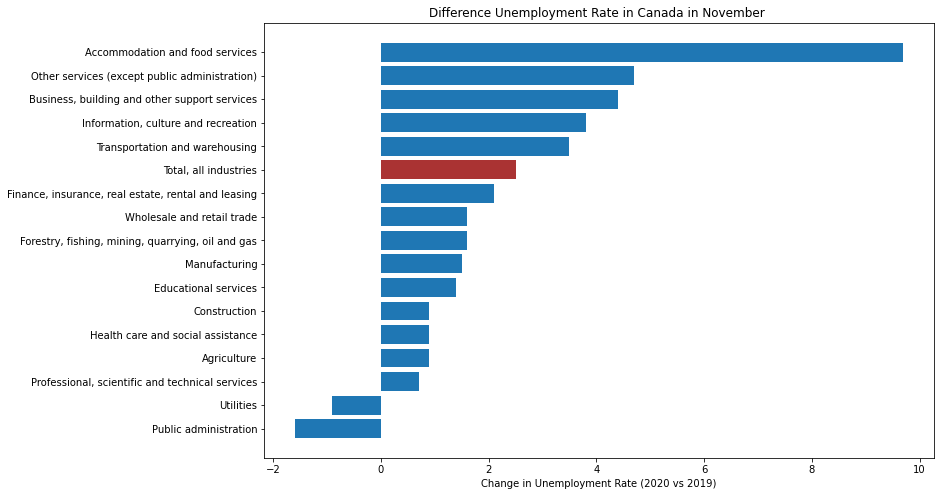

In [9]:
fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(nov.index, nov['diff'], align='center')
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate (2020 vs 2019)')
ax.set_title('Difference Unemployment Rate in Canada in November ')
highlight = 'Total, all industries'
pos = nov.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')
plt.show()

With some differences, we see that the Canadian economy behave similarly to the USA.

Accommodation and food and services (Leisure and Hospitality), Information, culture and recreation (Information) and Transport and warehousing (Transport and utilities) are sitting at the top of Canadian and US gprah in terms of change in unemployment.

Note that Public administration and Utilities did better than last year (diminution in unemployment).

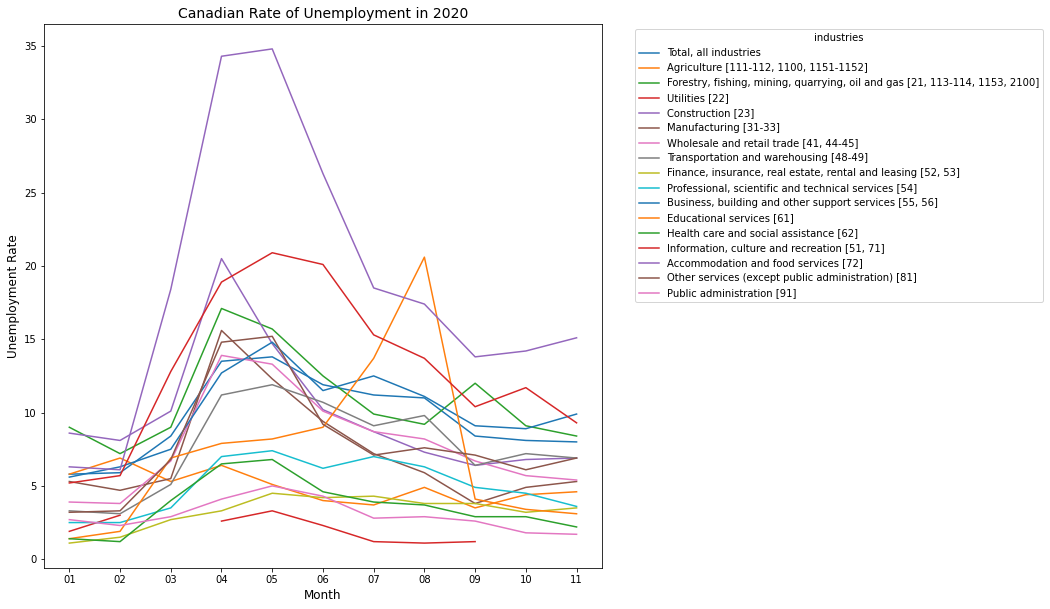

In [10]:
industries = df['North American Industry Classification System (NAICS)'].unique()
fig, ax = plt.subplots(nrows=1, sharey=True, figsize = (10,10))

for i in industries:
    tmp = query_year(df, naics=i, year='2020')
    ax.plot(tmp.DATE, tmp.VALUE, label = i)

plt.title('Canadian Rate of Unemployment in 2020', fontsize = 14)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Unemployment Rate', fontsize = 12)
plt.legend(title='industries', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')
plt.show()

* In this graph, we can see that Accommodations and Food Services is the most impacted over all.
* We also see that some industries have recovered faster (such as Construction).
* The orange spike is seasonnal unemployment in Agriculture.

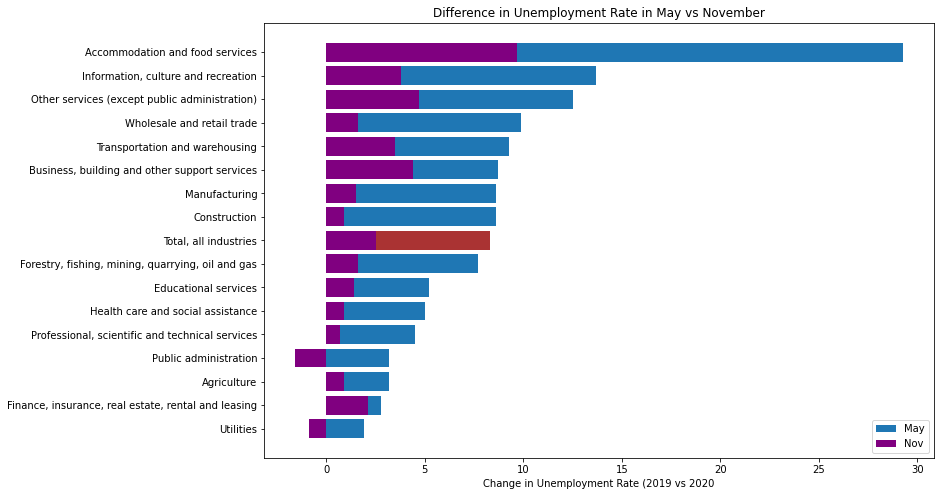

In [11]:
may2020 = query_month(df, month='2020-05')
may2019 = query_month(df, month='2019-05')
may = may2020.merge(may2019, on='NAICS')
may['diff'] = may['2020-05'] - may['2019-05']
may = may.sort_values('diff', ascending=False)
may = may.set_index('NAICS')

fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(may.index, may['diff'], align='center', label='May')
ax.barh(nov.index, nov['diff'], align='center', label='Nov', color='purple')
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate (2019 vs 2020')
ax.set_title('Difference in Unemployment Rate in May vs November')
highlight = 'Total, all industries'
pos = may.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')
plt.legend(loc='lower right')
plt.show()

As mentionned Wholesale and retail trade, Manufacturing and Construction have all recovered very fast.

So data closer to the publication date of the article are closer to their predictions.

In [12]:
nov2020 = query_month(df, labor='Employment', month='2020-05')
nov2019 = query_month(df, labor='Employment', month='2019-05')
nov = nov2020.merge(nov2019, on='NAICS')
nov['diff'] = nov['2020-05'] - nov['2019-05']
nov = nov.sort_values('diff', ascending=True)
nov = nov.loc[nov.NAICS != 'Total, all industries']
nov = nov.set_index('NAICS')

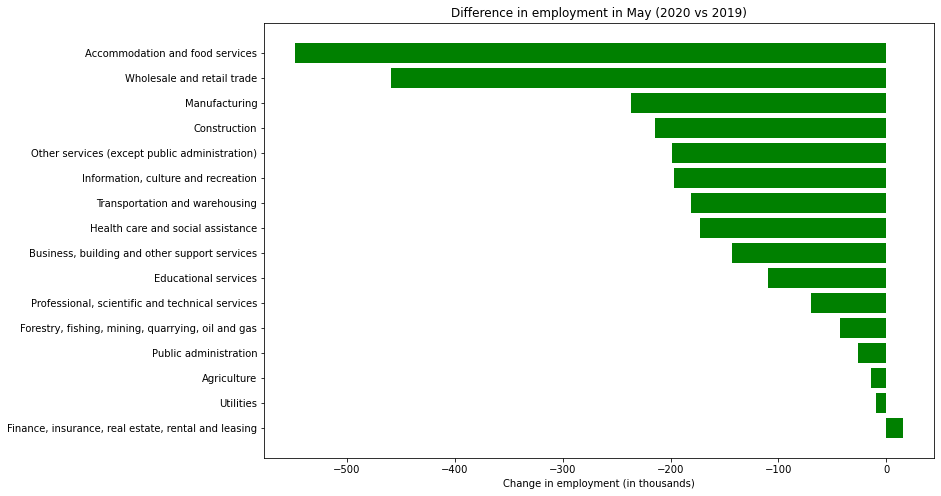

In [13]:
fig, ax = plt.subplots(figsize = (12,8)) 
ax.barh(nov.index, nov['diff'], align='center', color='g')
ax.invert_yaxis()
ax.set_xlabel('Change in employment (in thousands)')
ax.set_title('Difference in employment in May (2020 vs 2019)')
plt.show()

This graph take into account the size of the damages by showing the amount of job loss.

In terms of total job loss in May, the authors do well because the top 3 indutries are the one initially identified in the paper (Retail, Hospitality and Manufacturing).

In general, the paper is able to identify industries at risk but this approach fail to give the full portrait of the recovery and long term effect on the economy. Furthermore, the nature of data available through the SEC is limited to publicly traded compagny and ignore small businesses.

In [14]:
def query_province(df, province):
    prov2020 = query_month(df, geo=province, month='2020-11')
    prov2019 = query_month(df, geo=province, month='2019-11')
    prov = prov2020.merge(prov2019, on='NAICS')
    prov['diff'] = prov['2020-11'] - prov['2019-11']
    #prov = prov.sort_values('diff', ascending=False)
    prov = prov.set_index('NAICS')
    return prov

In [15]:
qc = query_province(df, 'Quebec')
on = query_province(df, 'Ontario')
al = query_province(df, 'Alberta')

prov = pd.DataFrame({'Quebec': qc['diff'],
                     'Ontario': on['diff'],
                     'Alberta': al['diff']}, 
                     index=qc.index).replace(np.nan, 0)

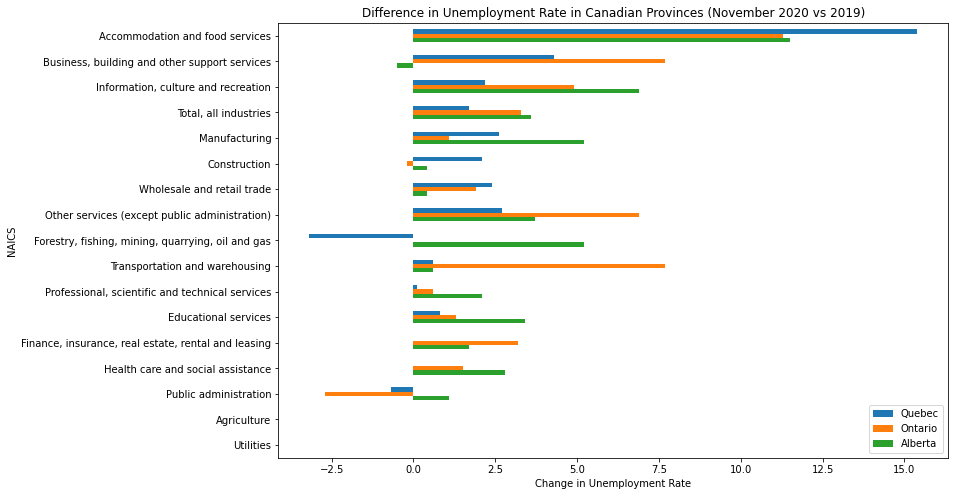

In [16]:
ax = prov.plot.barh(figsize = (12,8))
ax.invert_yaxis()
ax.set_xlabel('Change in Unemployment Rate')
ax.set_title('Difference in Unemployment Rate in Canadian Provinces (November 2020 vs 2019)')
plt.legend(loc='lower right')
plt.show()

Another problem is that, the main industries can differ from a province to another. Which is also not taken into account in this paper. 

For example, Alberta is highly hit in the Oil and gas industry. Same thing in Ontario with the Transport and Warehousing industry. 